In [1]:
import requests
import os
import re
from bs4 import BeautifulSoup
import pandas as pd
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import xml.etree.ElementTree as ET 
import nltk
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report
import pickle

In [2]:
# Download necessary NLTK data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab')


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\kingn\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\kingn\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\kingn\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\kingn\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

## Loadind Data into DataFrame


In [3]:
positive_reviews = []
negative_reviews = []

In [4]:
book_positive_reviews=BeautifulSoup(open("data/books/positive.review").read(), features="html5lib")
book_negative_reviews=BeautifulSoup(open("data/books/negative.review").read(), features="html5lib")
dvd_positive_reviews=BeautifulSoup(open("data/dvd/positive.review").read(), features="html5lib")
dvd_negative_reviews=BeautifulSoup(open("data/dvd/negative.review").read(), features="html5lib")
kitchen_positive_reviews=BeautifulSoup(open("data/kitchen_&_housewares/positive.review").read(), features="html5lib")
kitchen_negative_reviews=BeautifulSoup(open("data/kitchen_&_housewares/negative.review").read(), features="html5lib")
electronics_positive_reviews=BeautifulSoup(open("data/electronics/positive.review").read(), features="html5lib")
electronics_negative_reviews=BeautifulSoup(open("data/electronics/negative.review").read(), features="html5lib")

In [5]:
def clean_text(text):
    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    # Remove special characters and digits
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Convert to lowercase
    text = text.lower()
    return text

In [6]:
# cleaning the text
for review in book_positive_reviews.find_all('review_text'):
    positive_reviews.append(clean_text(review.text))
for review in book_negative_reviews.find_all('review_text'):
    negative_reviews.append(clean_text(review.text))
for review in dvd_positive_reviews.find_all('review_text'):
    positive_reviews.append(clean_text(review.text))
for review in dvd_negative_reviews.find_all('review_text'):
    negative_reviews.append(clean_text(review.text))
for review in kitchen_positive_reviews.find_all('review_text'):
    positive_reviews.append(clean_text(review.text))
for review in kitchen_negative_reviews.find_all('review_text'):
    negative_reviews.append(clean_text(review.text))
for review in electronics_positive_reviews.find_all('review_text'):
    positive_reviews.append(clean_text(review.text))
for review in electronics_negative_reviews.find_all('review_text'):
    negative_reviews.append(clean_text(review.text))


In [7]:
positive_reviews.__len__(), negative_reviews.__len__()

(4000, 4000)

In [8]:
data = {'Text': positive_reviews + negative_reviews, 'Sentiment': [1] * len(positive_reviews) + [0] * len(negative_reviews)}
df=pd.DataFrame(data)

## Data visualization


In [9]:
import matplotlib.pyplot as plt

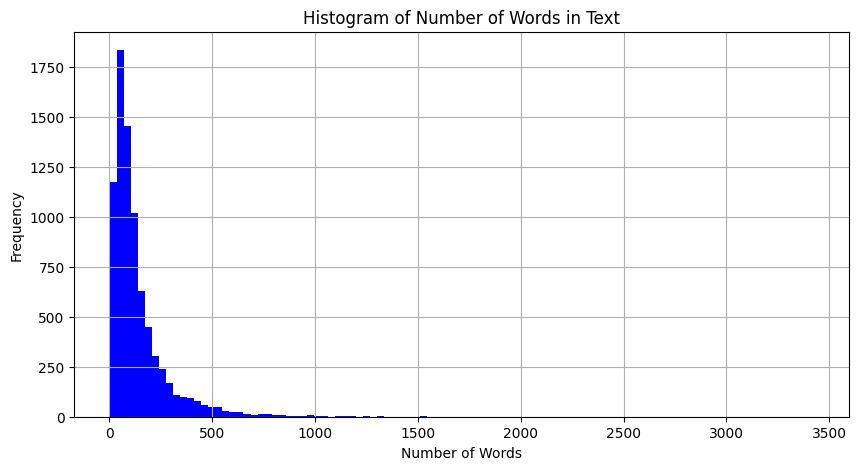

In [10]:
N_words=df.Text.apply(lambda x: len(x.split(" ")))
N_words.hist(bins=100, figsize=(10, 5), color='blue')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.title('Histogram of Number of Words in Text')
plt.show()

In [11]:

print("mean:" + str(N_words.mean()))
print("std:" + str(N_words.std()))
print("min:" + str(N_words.min()))
print("max:" + str(N_words.max()))

mean:137.62675
std:152.4850456457311
min:1
max:3427


In [12]:
df1=df.copy()
df1['N_words']=N_words

**Removing reviews which are more than 1000 words long**

In [13]:
df1 = df1[df1['N_words'] <= 1000]

<Axes: xlabel='Sentiment'>

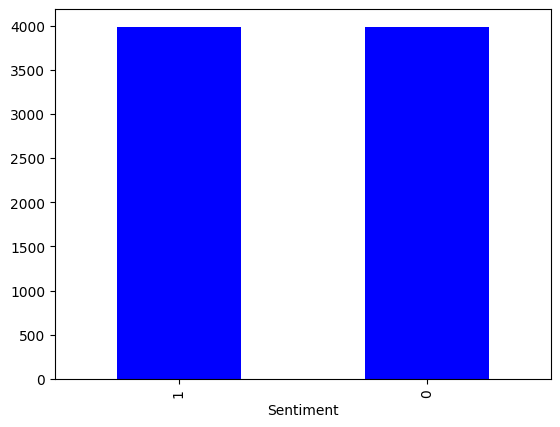

In [14]:
df1['Sentiment'].value_counts().plot(kind='bar', color='blue')

In [15]:
Sentiment_count=df1.Sentiment.value_counts()
Sentiment_count

Sentiment
1    3989
0    3985
Name: count, dtype: int64

In [16]:
from wordcloud import WordCloud

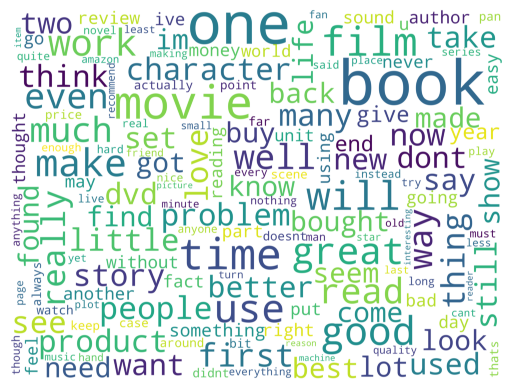

In [17]:

Words_cloud = " ".join(df.Text)
wordcloud = WordCloud(
    max_font_size=100,
    max_words=150,
    background_color="white",
    scale=10,
    width=800,
    height=600
).generate(Words_cloud)

plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

## Data Pre-Processing 

- Train: 64%
- Val: 16%
- Test: 20%

In [18]:
def preprocess_text(text):
    # Tokenization
    tokens = word_tokenize(text)
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]
    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    return ' '.join(tokens)

df1['Text'] = df1['Text'].apply(preprocess_text)

In [19]:
train_val, test = train_test_split(df1, test_size=0.2, random_state=42)
train, val = train_test_split(train_val, test_size=0.2, random_state=42)

In [20]:
train.shape, val.shape, test.shape

((5103, 3), (1276, 3), (1595, 3))

In [21]:
# remove N_words column
train = train.drop(columns=['N_words'])
val = val.drop(columns=['N_words'])
test = test.drop(columns=['N_words'])

### for sequentail model


In [22]:
train.to_csv('train.csv', index=False)
test.to_csv('test.csv', index=False)
val.to_csv('val.csv', index=False)

## Sequence Model Define


In [23]:
train_data = pd.read_csv('train.csv')
val_data = pd.read_csv('val.csv')
test_data = pd.read_csv('test.csv')

In [24]:
vectorizer=TfidfVectorizer(stop_words='english', max_features=1000)
X_train=vectorizer.fit_transform(train_data['Text'])
X_val=vectorizer.transform(val_data['Text'])
X_test=vectorizer.transform(test_data['Text'])


In [25]:
X_train.shape, X_val.shape, X_test.shape

((5103, 1000), (1276, 1000), (1595, 1000))

In [26]:
le = LabelEncoder()
y_train = le.fit_transform(train_data['Sentiment'])
y_val = le.transform(val_data['Sentiment'])
y_test = le.transform(test_data['Sentiment'])

In [27]:
model = Sequential([
    Dense(128, activation='relu', input_shape=(1000,)),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

c:\Users\kingn\OneDrive\Desktop\sentiment\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [28]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │       128,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 138,497 (541.00 KB)

 Trainable params: 138,497 (541.00 KB)

 Non-trainable params: 0 (0.00 B)

In [29]:
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

In [30]:
early_stopping = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=32, callbacks=[early_stopping])


Epoch 1/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5261 - loss: 0.6870 - val_accuracy: 0.7813 - val_loss: 0.5070
Epoch 2/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7634 - loss: 0.4911 - val_accuracy: 0.7994 - val_loss: 0.4190
Epoch 3/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8474 - loss: 0.3708 - val_accuracy: 0.8158 - val_loss: 0.4177
Epoch 4/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8822 - loss: 0.2988 - val_accuracy: 0.8064 - val_loss: 0.4288
Epoch 5/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9053 - loss: 0.2511 - val_accuracy: 0.8080 - val_loss: 0.4608
Epoch 6/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9348 - loss: 0.1824 - val_accuracy: 0.8049 - val_loss: 0.5112
Epoch 7/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9583 - loss: 0.1312 - val_accuracy: 0.7939 - val_loss: 0.5714
Epoch 8/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9630 - loss: 0.1051 - val_accuracy: 0.

In [31]:
# Evaluate model
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_accuracy:.4f}")

# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.savefig('training_history.png')
plt.close()

# Save model
model.save('sentiment_model.h5')
with open('vectorizer.pkl', 'wb') as handle:
    pickle.dump(vectorizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

print("Model training completed. Model saved as 'sentiment_model.h5'")

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 672us/step - accuracy: 0.7682 - loss: 0.4837
Test accuracy: 0.7655


Model training completed. Model saved as 'sentiment_model.h5'


In [32]:
# Make predictions on the test data
y_pred = model.predict(X_test)
# Convert predictions to binary values
y_pred_binary = (y_pred >= 0.5).astype(int)
# Generate classification report
report = classification_report(y_test, y_pred_binary)
print(report)

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
              precision    recall  f1-score   support

           0       0.77      0.75      0.76       795
           1       0.76      0.78      0.77       800

    accuracy                           0.77      1595
   macro avg       0.77      0.77      0.77      1595
weighted avg       0.77      0.77      0.77      1595



In [35]:
def predict_sentiment(text):
    text = preprocess_text(text)
    text = vectorizer.transform([text])
    prediction = model.predict(text)
    return 'Positive' if prediction[0][0] >= 0.5 else 'Negative'

In [37]:
predict_sentiment("Well its not bad like i thought it would be")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


'Negative'